In [1]:
"""
1.特征提取：使用先前网络学习表示新样本的特征。只需要再预训练模型上添加一个分类器
2.微调：解冻一些顶层，进行巽离岸
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-04-29 08:26:04.191065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 08:26:05.037822: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 08:26:05.040575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 08:26:08.269116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [12]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [13]:
print(next(iter(train_dataset))[0].shape)
print(next(iter(train_dataset))[1].shape)

(32, 160, 160, 3)


2023-04-29 08:26:38.644986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-29 08:26:38.645857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


(32,)


In [14]:
_

21

In [15]:
# 创建测试集
# tf.data.experimental.cardinality：确定验证集的批次，
# 然后将其中20%移至测试集

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [16]:
print('Number of validation batches: %d' %  tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [17]:
len(validation_dataset)

26

In [18]:
# 配置数据集以提高性能
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [21]:
# 数据增强
# 旋转、翻转
# 这些层只有在训练过程中有效，在测试过程中处于停用状态
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

2023-04-29 08:49:04.229610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-29 08:49:04.231518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


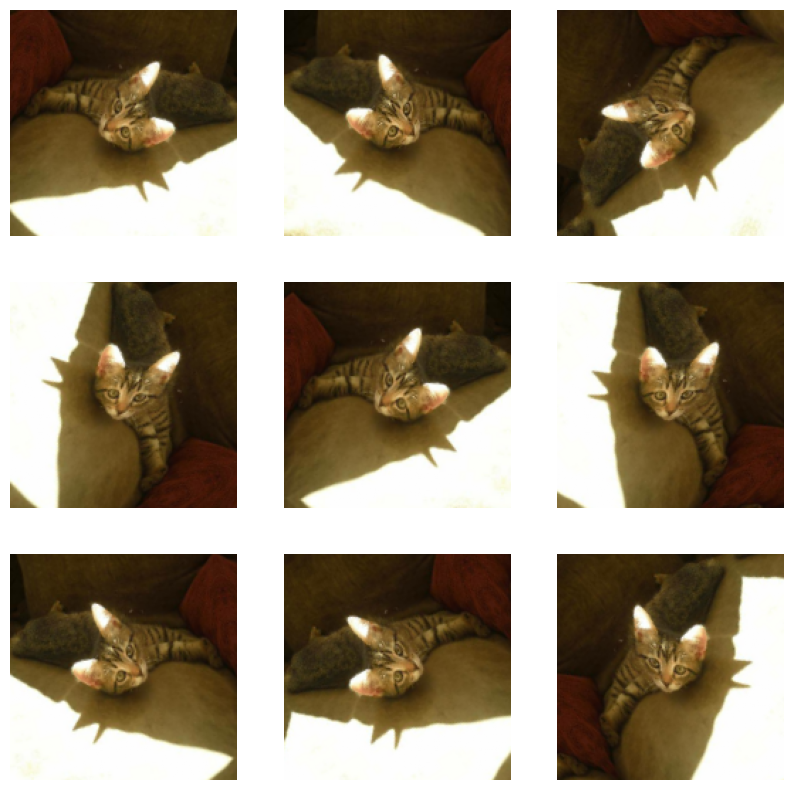

In [26]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        # 加入数据增强层
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

In [27]:
# 处理像素值
# 我们的像素值在[0,255]之间，而模型期望像素值是[-1,1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# 或者，定义rescale层
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [29]:
"""
⭐构建预训练基础模型——MobileNet V2，基于ImageNet
    ·要确定哪一层进行特征提取。（最后一层：瓶颈层）
    ·include_top = False：加载不包括顶部分类层的网络
"""
# IMG_SHAPE:(160,160,3)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [30]:
# 特征提取程序将 160×160×3的图像转化为了5×5×1280的特征块
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(image_batch.shape)
print(feature_batch.shape)

2023-04-29 08:58:58.362611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-29 08:58:58.363476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


(32, 160, 160, 3)
(32, 5, 5, 1280)


In [31]:
# 冻结卷积模型
base_model.trainable = False

In [32]:
# BatchNormalization在冻结模型时会以推断模式运行；
# 在运行时需要传递trainning=False来确保Batchnromalization在推断模式下
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [34]:
# 添加分类头
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [35]:
prediction_layer = tf.keras.layers.Dense(1)
predict_batch = prediction_layer(feature_batch_average)
print(predict_batch.shape)

(32, 1)


In [36]:
# ⭐使用函数时API对数据扩充、缩放、basemodel和特征提取程序层进行连接
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [28]:
# 分为两个Variable对象
len(model.trainable_variables)

2

In [39]:
# 训练模型
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

2023-04-29 09:28:11.770504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-29 09:28:11.771410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - 4s 87ms/step - loss: 1.0959 - accuracy: 0.2537
initial loss: 1.10
initial accuracy: 0.25


In [40]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 12s 141ms/step - loss: 0.8831 - accuracy: 0.4615 - val_loss: 0.7491 - val_accuracy: 0.4975
Epoch 2/10
63/63 [==============================] - 8s 131ms/step - loss: 0.6428 - accuracy: 0.6190 - val_loss: 0.5310 - val_accuracy: 0.6881
Epoch 3/10
63/63 [==============================] - 8s 132ms/step - loss: 0.4990 - accuracy: 0.7340 - val_loss: 0.4045 - val_accuracy: 0.8069
Epoch 4/10
63/63 [==============================] - 8s 125ms/step - loss: 0.4092 - accuracy: 0.7955 - val_loss: 0.3241 - val_accuracy: 0.8663
Epoch 5/10
63/63 [==============================] - 8s 126ms/step - loss: 0.3656 - accuracy: 0.8275 - val_loss: 0.2689 - val_accuracy: 0.8861
Epoch 6/10
63/63 [==============================] - 8s 125ms/step - loss: 0.3189 - accuracy: 0.8560 - val_loss: 0.2338 - val_accuracy: 0.8973
Epoch 7/10
63/63 [==============================] - 8s 125ms/step - loss: 0.2818 - accuracy: 0.8785 - val_loss: 0.1968 - val_accuracy: 0.9257
Epoch

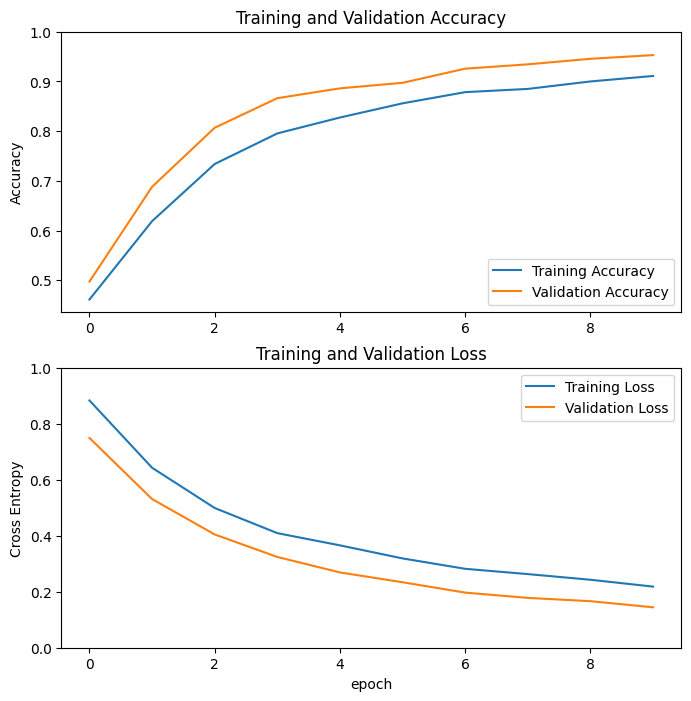

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
# ⭐ 微调
# 应该微调少量顶层，而不是整个模型。
# 在大多数卷积神经网络中，层越高，学习到的专门程度就越高
# 对于顶层进行微调，有助于模型适应自己的数据
base_model.trainable = True

# base_model的层数
print("Number of the layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
# 冻结前100层
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of the layers in the base model:  154


In [43]:
# RMSprop：基于Adagrad的优化算法
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
             metrics=['accuracy'])

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [46]:
len(model.trainable_variables)

56

In [45]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

26/26 [==============================] - 4s 86ms/step - loss: 0.1527 - accuracy: 0.9493
initial loss: 0.15
initial accuracy: 0.95


In [46]:
# 基于先前的模型继续训练至收敛，
# fine_tune后，精度达到了98%
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                        epochs=total_epochs,
                        initial_epoch=history.epoch[-1],
                        validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 17s 174ms/step - loss: 0.1555 - accuracy: 0.9345 - val_loss: 0.0629 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 11s 170ms/step - loss: 0.1215 - accuracy: 0.9525 - val_loss: 0.0505 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 11s 167ms/step - loss: 0.1194 - accuracy: 0.9515 - val_loss: 0.0478 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 10s 166ms/step - loss: 0.0940 - accuracy: 0.9590 - val_loss: 0.0427 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 10s 163ms/step - loss: 0.1003 - accuracy: 0.9595 - val_loss: 0.0387 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 10s 164ms/step - loss: 0.0852 - accuracy: 0.9610 - val_loss: 0.0478 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 10s 163ms/step - loss: 0.0877 - accuracy: 0.9640 - val_loss: 0.0438 - val_accuracy:

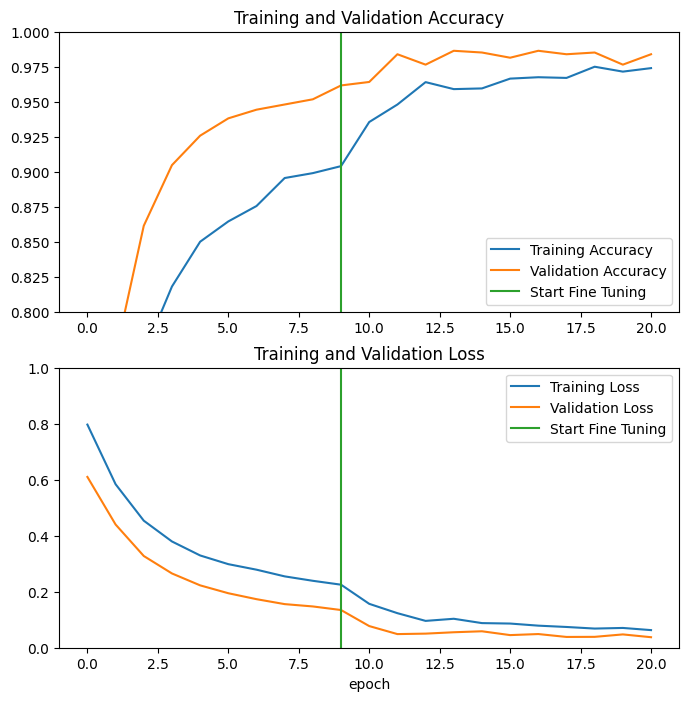

In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)--
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 82ms/step - loss: 0.0331 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


2023-04-26 15:52:54.906260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,160,160,3]
	 [[{{node Placeholder/_0}}]]


Predictions:
 [0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1]
Labels:
 [0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1]


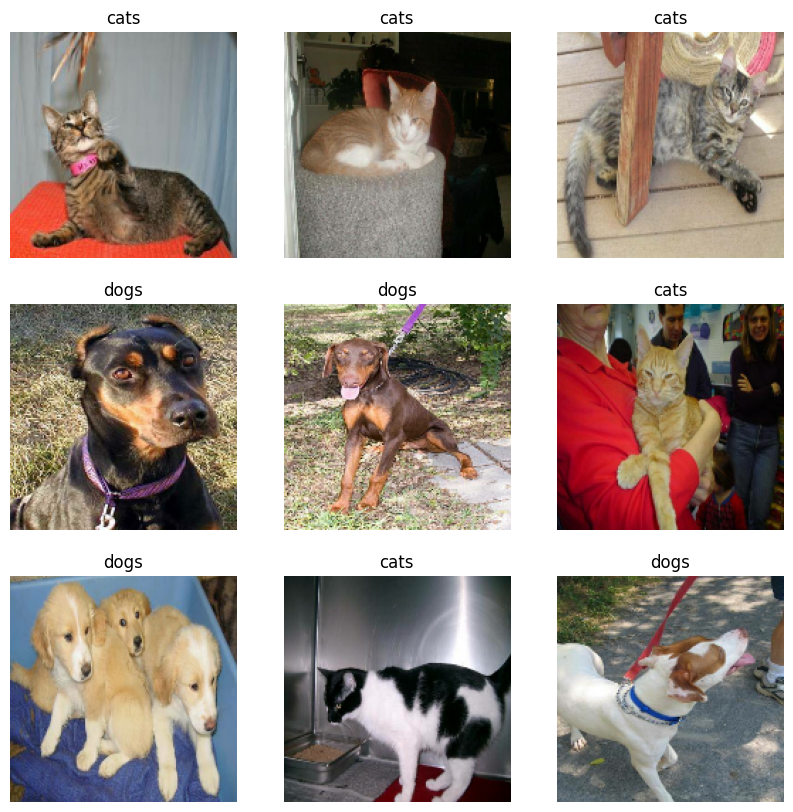

In [70]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(classes_name[predictions[i]])
    plt.axis("off")

总结
使用预训练模型进行特征提取：使用小型数据集时，常见做法是利用基于相同域中的较大数据集训练的模型所学习的特征。为此，您需要实例化预训练模型并在顶部添加一个全连接分类器。预训练模型处于“冻结状态”，训练过程中仅更新分类器的权重。在这种情况下，卷积基提取了与每个图像关联的所有特征，而您刚刚训练了一个根据给定的提取特征集确定图像类的分类器。

微调预训练模型：为了进一步提高性能，可能需要通过微调将预训练模型的顶层重新用于新的数据集。在本例中，您调整了权重，以使模型学习特定于数据集的高级特征。当训练数据集较大且与训练预训练模型所使用的原始数据集非常相似时，通常建议使用这种技术。